协方差函数（核函数），使用 常数核 * RBF核 的形式

In [1]:
import numpy as np

def gaussian_kernel(x1, x2, l=1.0, sigma_f=1.0):
    """Easy to understand but inefficient."""
    m, n = x1.shape[0], x2.shape[0]
    dist_matrix = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = np.sum((x1[i] - x2[j]) ** 2)
    return sigma_f ** 2 * np.exp(- 0.5 / l ** 2 * dist_matrix)

def gaussian_kernel_vectorization(x1, x2, l=1.0, sigma_f=1.0):
    """More efficient approach."""
    dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

x = np.array([700, 800, 1029]).reshape(-1, 1)
print(gaussian_kernel_vectorization(x, x, l=500, sigma_f=10))

[[100.          98.01986733  80.5347031 ]
 [ 98.01986733 100.          90.04307671]
 [ 80.5347031   90.04307671 100.        ]]


--------------

# 实现简单高斯过程回归

In [2]:
from scipy.optimize import minimize

class GPR:

    def __init__(self, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 0.5, "sigma_f": 0.2}
        self.optimize = optimize

    def fit(self, X, y):
        # store train data
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)
        self.is_fit = True

    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return

        X = np.asarray(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)

        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov

    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)

定义一个余弦目标函数：

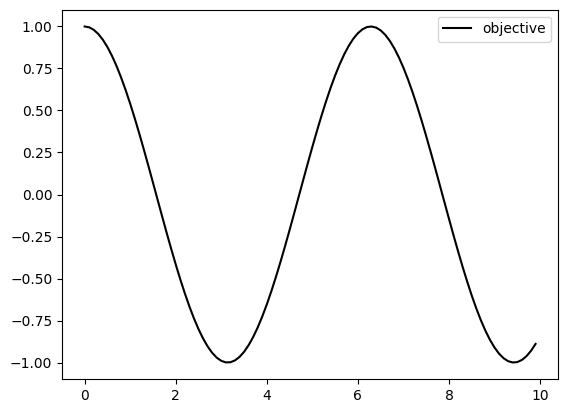

In [3]:
from matplotlib import pyplot as plt

def y(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape)
    return y.tolist()
    
test_X = np.arange(0, 10, 0.1).reshape(-1, 1)

plt.figure()
plt.plot(test_X, y(test_X), label="objective", c='#000000')
plt.legend()

5个观测点作为训练数据集，进行高斯过程回归：

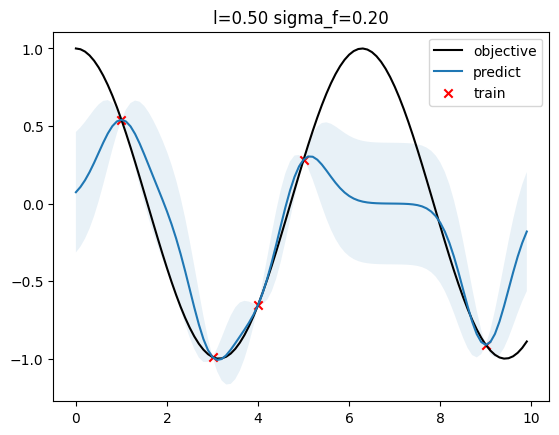

In [4]:
train_X = np.array([3, 1, 4, 5, 9]).reshape(-1, 1)
train_y = y(train_X, noise_sigma=1e-4)

gpr = GPR()
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
conf95width = 1.96 * np.sqrt(np.diag(cov))

plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + conf95width, test_y - conf95width, alpha=0.1)
plt.plot(test_X, y(test_X), label="objective", c='#000000')
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

# 改进fit方法使得GPR类能自动优化超参数：

In [5]:
class GPR:

    def __init__(self, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 0.5, "sigma_f": 0.2}
        self.optimize = optimize

    def fit(self, X, y):
        # store train data
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)

         # hyper parameters optimization
        def negative_log_likelihood_loss(params):
            self.params["l"], self.params["sigma_f"] = params[0], params[1]
            Kyy = self.kernel(self.train_X, self.train_X) + 1e-8 * np.eye(len(self.train_X))
            loss = 0.5 * self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + 0.5 * np.linalg.slogdet(Kyy)[1] + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            return loss.ravel()

        if self.optimize:
            res = minimize(negative_log_likelihood_loss, [self.params["l"], self.params["sigma_f"]],
                   bounds=((1e-4, 1e4), (1e-4, 1e4)),
                   method='L-BFGS-B')
            self.params["l"], self.params["sigma_f"] = res.x[0], res.x[1]

        self.is_fit = True

    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return

        X = np.asarray(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)

        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov

    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)

此时对同样的数据集进行学习，预测效果有明显不同：

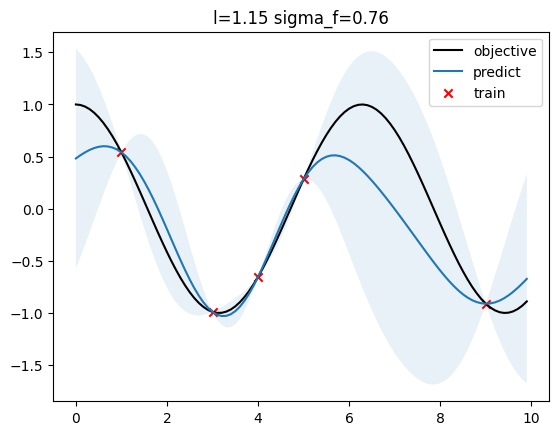

In [6]:
gpr = GPR()
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
conf95width = 1.96 * np.sqrt(np.diag(cov))
plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + conf95width, test_y - conf95width, alpha=0.1)
plt.plot(test_X, y(test_X), label="objective", c='#000000')
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

### 使用sklearn的GaussianProcessRegressor接口进行学习，可以达成同样的效果：

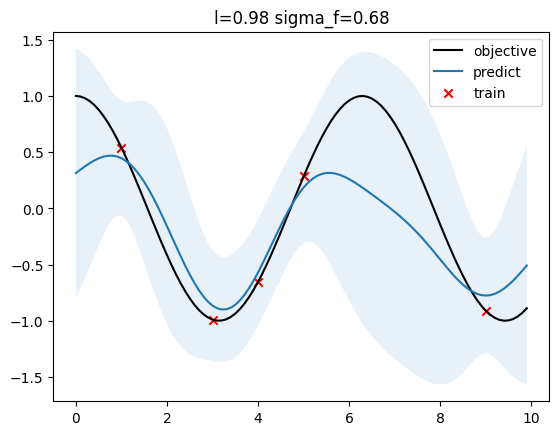

In [24]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

kernel = 1.0**2 * RBF(length_scale=0.5, length_scale_bounds=(1e-4, 1e4)) ### 问题1
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, alpha=0.08)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X, return_cov=True)
test_y = mu.ravel()
conf95width = 1.96 * np.sqrt(np.diag(cov))

plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.kernel_.k2.length_scale, np.sqrt(gpr.kernel_.k1.constant_value)))
plt.fill_between(test_X.ravel(), test_y + conf95width, test_y - conf95width, alpha=0.1)
plt.plot(test_X, y(test_X), label="objective", c='#000000')
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

-------------

### 问题1：

此处"1.0 ** 2"这一项有什么作用？如果去掉，对结果有何影响？

### 问题2：

请修改自定义的GPR类，使其能接收训练数据的观测不确定度（实现等价于GaussianProcessRegressor的参数alpha的功能）

-----------------

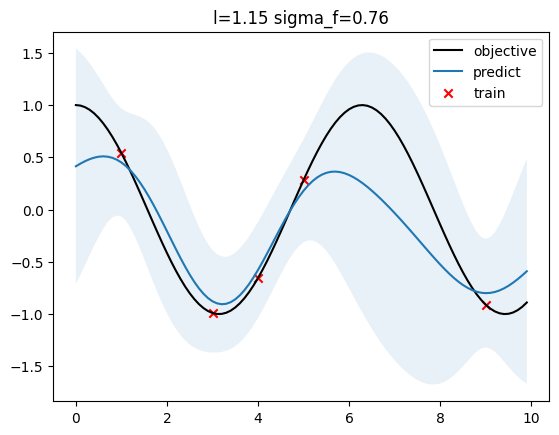

In [18]:
class GPR:

    def __init__(self, alpha=1e-8, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 0.5, "sigma_f": 0.2}
        self.alpha = alpha
        self.optimize = optimize

    def fit(self, X, y):
        # store train data
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)

         # hyper parameters optimization
        def negative_log_likelihood_loss(params):
            self.params["l"], self.params["sigma_f"] = params[0], params[1]
            Kyy = self.kernel(self.train_X, self.train_X) + 1e-8 * np.eye(len(self.train_X))
            loss = 0.5 * self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + 0.5 * np.linalg.slogdet(Kyy)[1] + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            return loss.ravel()

        if self.optimize:
            res = minimize(negative_log_likelihood_loss, [self.params["l"], self.params["sigma_f"]],
                   bounds=((1e-4, 1e4), (1e-4, 1e4)),
                   method='L-BFGS-B')
            self.params["l"], self.params["sigma_f"] = res.x[0], res.x[1]

        self.is_fit = True

    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return

        X = np.asarray(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + self.alpha * np.eye(len(self.train_X)))  # (N, N)

        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov

    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)


gpr = GPR(alpha=0.08)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
conf95width = 1.96 * np.sqrt(np.diag(cov))
plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + conf95width, test_y - conf95width, alpha=0.1)
plt.plot(test_X, y(test_X), label="objective", c='#000000')
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

相关链接：

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html?highlight=rbf#sklearn.gaussian_process.kernels.RBF

https://borgwang.github.io/ml/2019/07/28/gaussian-processes.html

http://www.gaussianprocess.org/gpml/chapters/RW.pdf （Gaussian Process for Machine Learning）